In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

c:\Users\USER\OneDrive - UNIVERSITAS INDONESIA\COOLYEAH\smt 8\tugas akhir\topic-modelling\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df_03 = pd.read_csv('data/stemmed_merged_kubu_03.csv')
df_03['created_at'] = pd.to_datetime(df_03['created_at'])
df_03['date'] = df_03['created_at'].dt.date


In [3]:
indo_stopwords = [
    # Basic Indonesian stopwords
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    
    # Candidate names and references (since they appear in nearly every tweet)
    "ganjar", "pranowo", "mahfud", "md", "gp", "gama", "prabowo", "gibran", "megawati", "03"
    
    # Common Balinese campaign greeting (appears frequently)
    "rahajeng", "rawuh", "bal", "bali", "dewata", "pulau",
    
    
    # Location indicators
    "indonesia", "jakarta", "jawa", "timur", "barat", "tengah", "sumatra", "utara", 
    "selatan", "kota", "daerah", "provinsi", "wilayah", "region",
]

In [4]:

vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=5,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=10,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)

timestamps = df_03['created_at'].tolist()

# Fit the model
topics, probs = topic_model.fit_transform(df_03['full_text'].tolist())

2025-05-24 10:05:16,018 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1183/1183 [06:30<00:00,  3.03it/s]
2025-05-24 10:11:47,030 - BERTopic - Embedding - Completed ✓
2025-05-24 10:11:47,031 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-24 10:12:51,771 - BERTopic - Dimensionality - Completed ✓
2025-05-24 10:12:51,773 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-24 10:28:17,348 - BERTopic - Cluster - Completed ✓
2025-05-24 10:28:17,349 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-24 10:28:18,993 - BERTopic - Representation - Completed ✓
2025-05-24 10:28:18,994 - BERTopic - Topic reduction - Reducing number of topics
2025-05-24 10:28:19,047 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-24 10:28:20,118 - BERTopic - Representation - Completed ✓
2025-05-24 10:28:20,122 - BERTopic - Topic reduction - 

In [5]:
# Generate more intuitive topic labels for Ganjar's campaign

# Create a topics over time analysis
topics_over_time = topic_model.topics_over_time(
    docs=df_03['full_text'].tolist(),
    timestamps=timestamps,
    global_tuning=True,
    evolution_tuning=True,
    nr_bins=14  # Roughly 1 bin per day for a two-week analysis
)

topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Outlier"
        continue
        
    # Get top words
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to Ganjar campaign themes based on keywords
    if any(term in words for term in ["bal", "bali", "rahajeng", "rawuh"]):
        topic_labels[topic_id] = "Kampanye Bali"
    elif any(term in words for term in ["jawa", "tengah", "jateng", "banteng"]):
        topic_labels[topic_id] = "Basis Dukungan Jawa Tengah"
    elif any(term in words for term in ["legislatif", "eksekutif", "yudikatif", "jejak", "rekam"]):
        topic_labels[topic_id] = "Pengalaman Pemerintahan"
    elif any(term in words for term in ["fokus", "dukung", "motivasi", "kembang"]):
        topic_labels[topic_id] = "Dukungan & Motivasi"
    elif any(term in words for term in ["demokrasi", "partai", "pdip", "banteng", "merah"]):
        topic_labels[topic_id] = "Dukungan Partai PDI-P"
    elif any(term in words for term in ["dame", "hati", "adem", "damai", "sejuk"]):
        topic_labels[topic_id] = "Citra Kepemimpinan Adem"
    elif any(term in words for term in ["aspirasi", "dengar", "blusuk", "jumpa"]):
        topic_labels[topic_id] = "Pendekatan ke Masyarakat"
    elif any(term in words for term in ["tegak", "lurus", "jujur", "bersih"]):
        topic_labels[topic_id] = "Integritas & Kejujuran"
    elif any(term in words for term in ["huru", "hara", "politik", "sembuh", "luka"]):
        topic_labels[topic_id] = "Perbaikan Situasi Politik"
    elif any(term in words for term in ["penjuru", "nusantara", "kenal"]):
        topic_labels[topic_id] = "Popularitas Nasional"
    else:
        # Use the first few words as a generic label
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)

topics_over_time["Name"] = topics_over_time["Topic"].map(
    lambda x: topic_model.get_topic_info().set_index("Topic").loc[x, "Name"]
    if x in topic_model.get_topic_info()["Topic"].values else f"Topic {x}")

14it [00:01, 11.20it/s]


In [6]:
from wordcloud import WordCloud
import seaborn as sns
# import mdates
import matplotlib.dates as mdates

<Figure size 2000x1000 with 0 Axes>

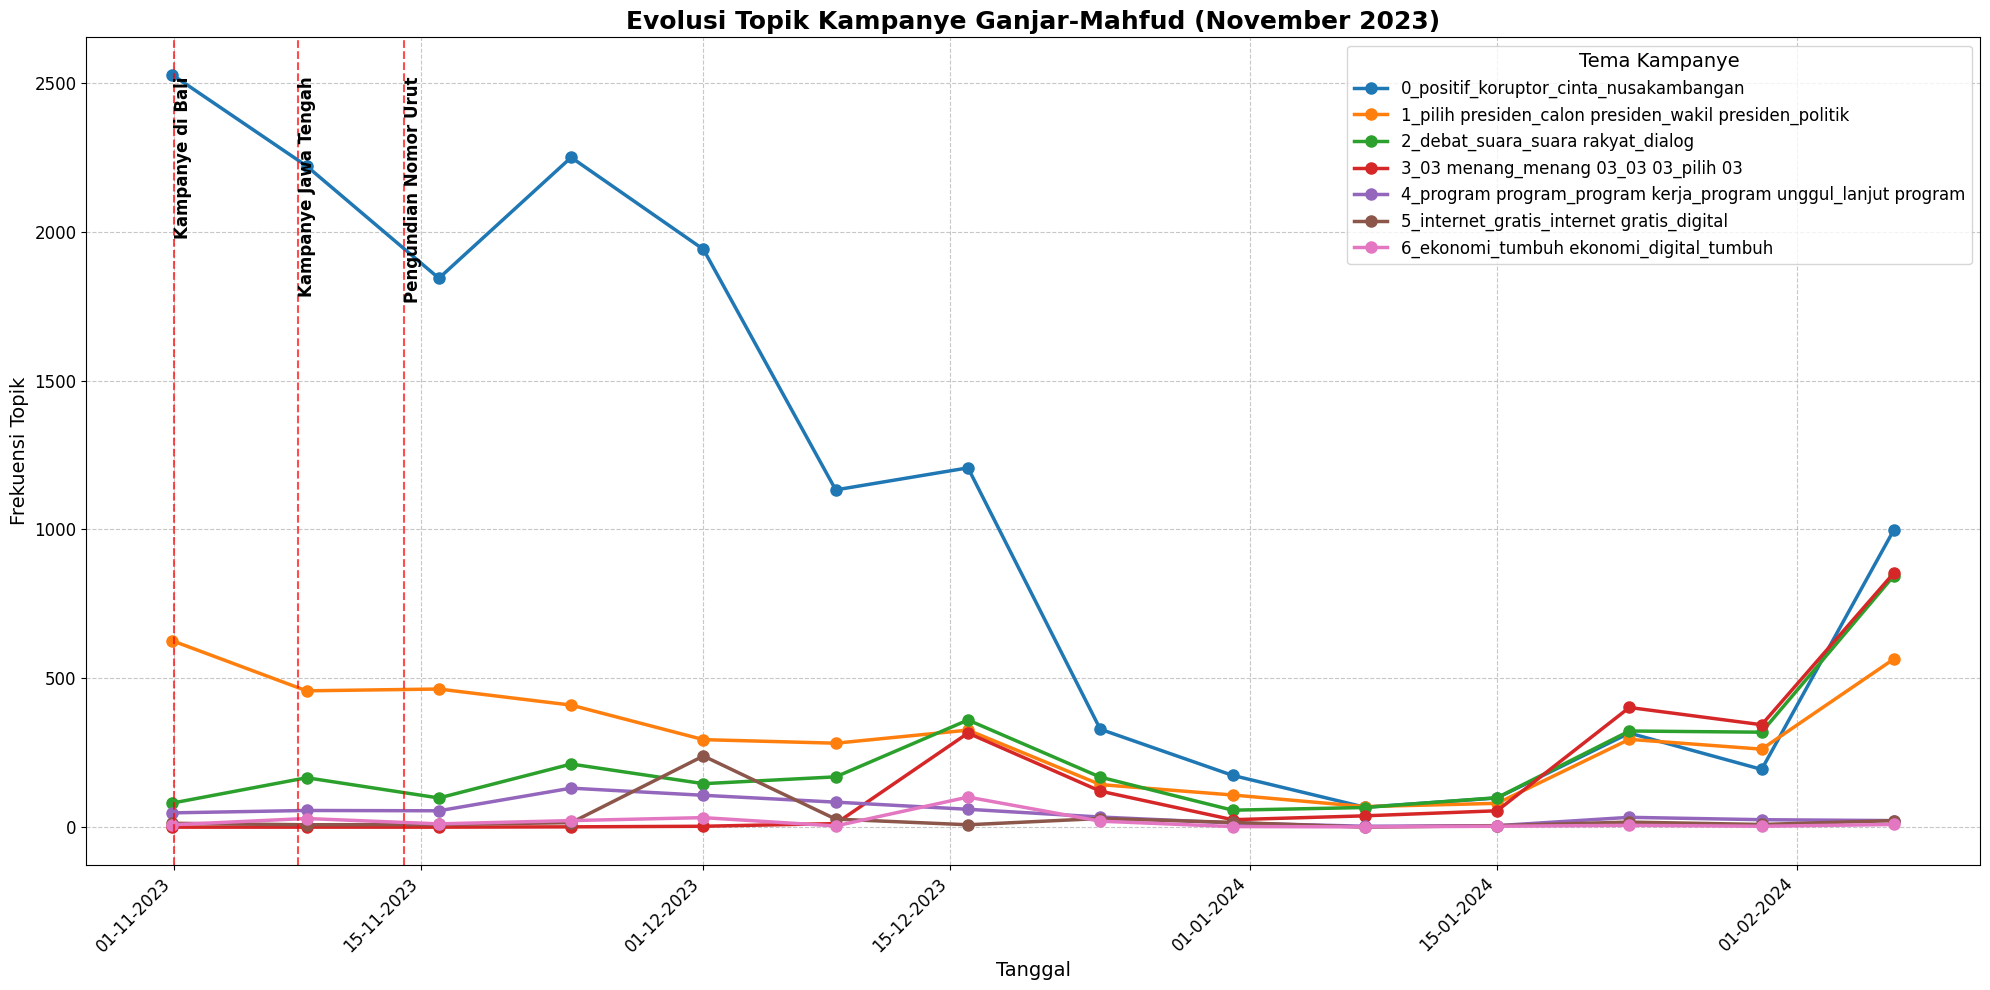

<Figure size 2000x1000 with 0 Axes>

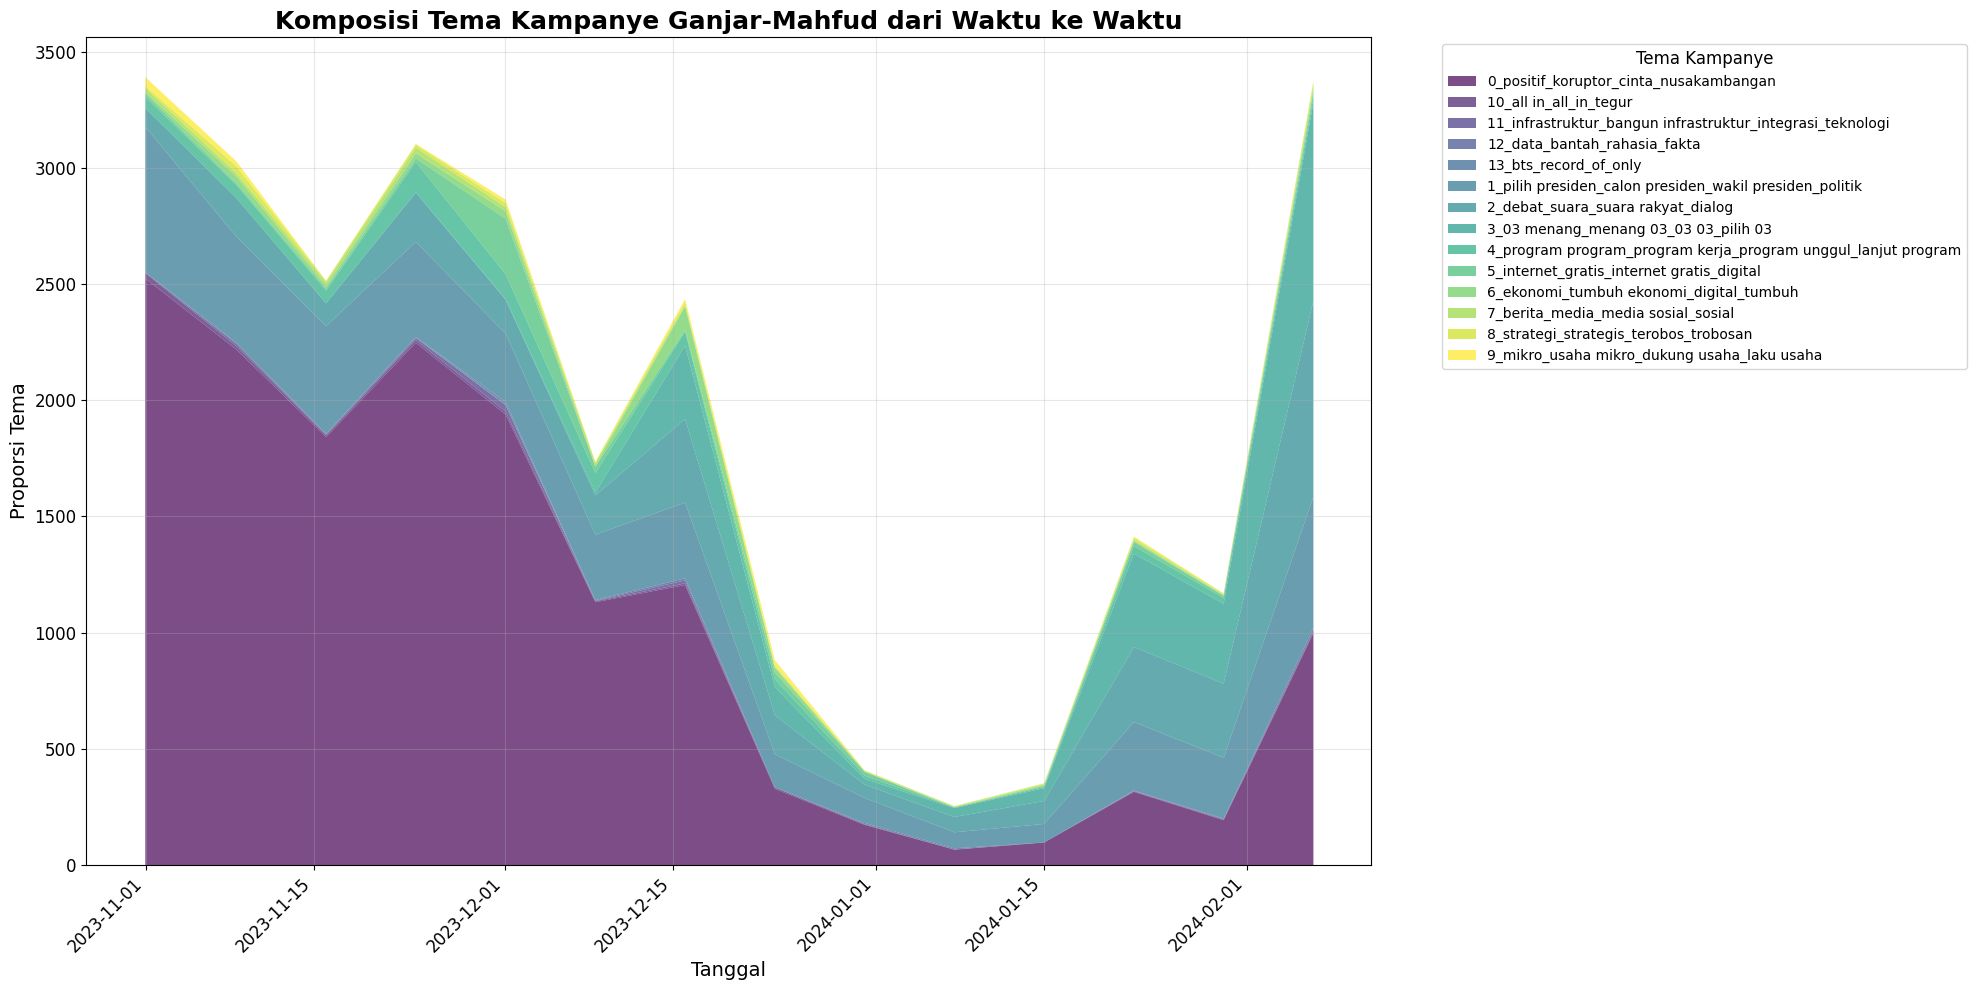

In [7]:
# Create a line plot showing topic prevalence over time
plt.figure(figsize=(20, 10))

# Get top topics excluding outliers
top_topics = [topic for topic in topic_model.get_topic_info()["Topic"][:8] if topic != -1]
topic_names = [topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic, "Name"].values[0] 
               for topic in top_topics]

# Filter the topics_over_time DataFrame to include only top topics
filtered_tot = topics_over_time[topics_over_time["Topic"].isin(top_topics)]

# Create a pivot table for easier plotting
pivot_data = pd.pivot_table(
    data=filtered_tot,
    index="Timestamp", 
    columns="Name",
    values="Frequency",
    aggfunc="sum"
).fillna(0)

# Plot the data with a better style
ax = pivot_data.plot(kind='line', marker='o', markersize=8, figsize=(20, 10), linewidth=2.5)

# Format the plot
plt.title("Evolusi Topik Kampanye Ganjar-Mahfud (November 2023)", fontsize=18, fontweight='bold')
plt.xlabel("Tanggal", fontsize=14)
plt.ylabel("Frekuensi Topik", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title="Tema Kampanye", fontsize=12, title_fontsize=14)
plt.tight_layout()

# Format date axis to be more readable
date_format = mdates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
plt.grid(True, linestyle='--', alpha=0.7)

# Add date markers for key events
key_events = {
    "2023-11-14": "Pengundian Nomor Urut",
    "2023-11-08": "Kampanye Jawa Tengah",
    "2023-11-01": "Kampanye di Bali"
}

# Add vertical lines for key events
for date_str, event_name in key_events.items():
    event_date = pd.to_datetime(date_str)
    if event_date >= pivot_data.index.min() and event_date <= pivot_data.index.max():
        plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.7)
        plt.text(event_date, plt.ylim()[1]*0.95, event_name, rotation=90, 
                 verticalalignment='top', fontsize=12, fontweight='bold')

plt.show()

# Area chart showing the full topic composition over time
plt.figure(figsize=(20, 10))

# Create a stacked area chart
pivot_data_all = pd.pivot_table(
    data=topics_over_time[topics_over_time["Topic"] != -1],  # Exclude outliers
    index="Timestamp", 
    columns="Name",
    values="Frequency",
    aggfunc="sum"
).fillna(0)

# Plot as a stacked area chart
pivot_data_all.plot.area(figsize=(20, 10), alpha=0.7, linewidth=0, stacked=True, colormap='viridis')

# Format the plot
plt.title("Komposisi Tema Kampanye Ganjar-Mahfud dari Waktu ke Waktu", fontsize=18, fontweight='bold')
plt.xlabel("Tanggal", fontsize=14)
plt.ylabel("Proporsi Tema", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title="Tema Kampanye", fontsize=10, title_fontsize=12, 
          bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

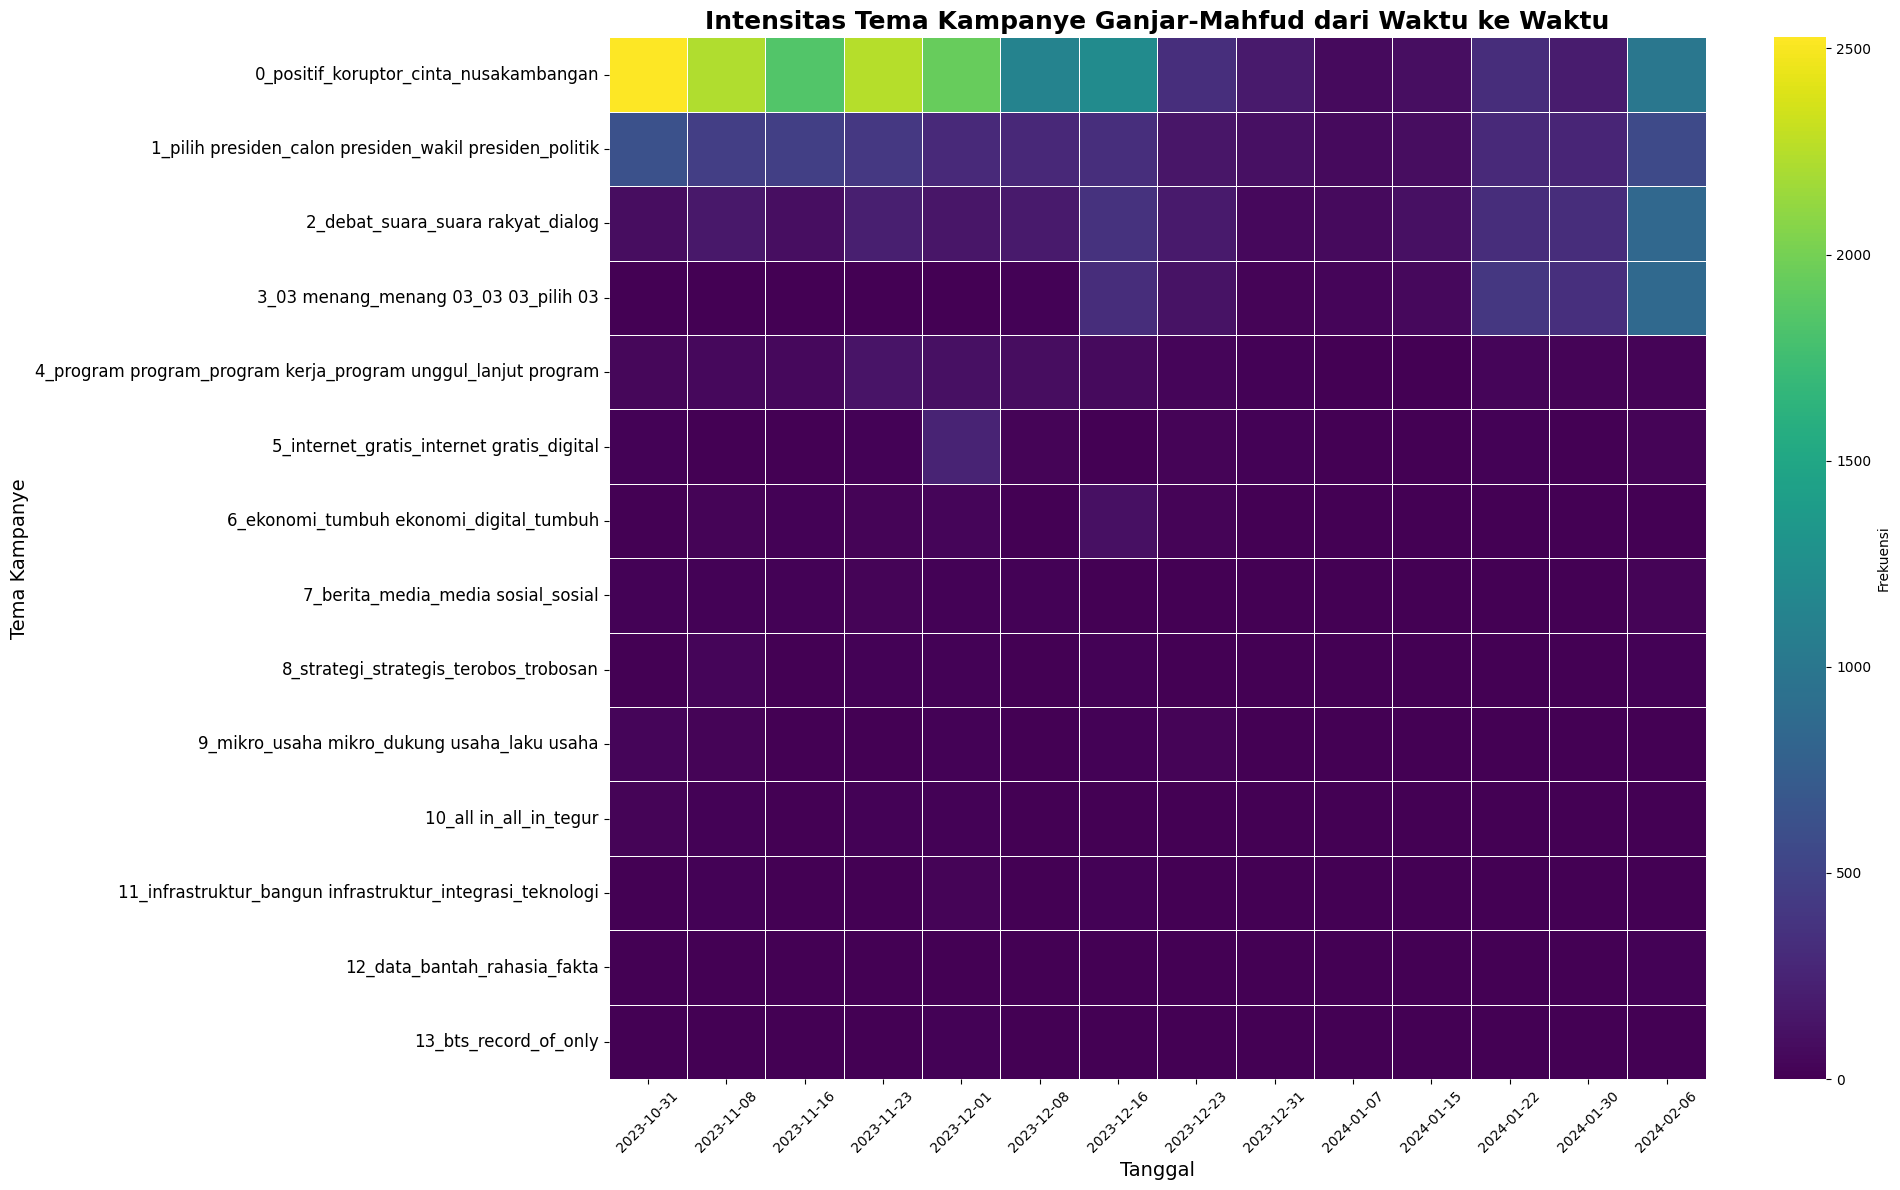

In [8]:
# Create a heatmap for topics over time to easily view patterns
plt.figure(figsize=(20, 12))

# Create a pivot table for the heatmap
heatmap_data = pd.pivot_table(
    data=topics_over_time[topics_over_time["Topic"] != -1],  # Exclude outliers
    index="Name", 
    columns=pd.to_datetime(topics_over_time["Timestamp"]).dt.date,
    values="Frequency",
    aggfunc="sum"
).fillna(0)

# Sort topics by average frequency
heatmap_data = heatmap_data.loc[heatmap_data.mean(axis=1).sort_values(ascending=False).index]

# Create the heatmap
sns.heatmap(heatmap_data, cmap="viridis", annot=False, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Frekuensi'})

# Format the plot
plt.title("Intensitas Tema Kampanye Ganjar-Mahfud dari Waktu ke Waktu", fontsize=18, fontweight='bold')
plt.xlabel("Tanggal", fontsize=14)
plt.ylabel("Tema Kampanye", fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [9]:
# Identify dates with significant topic shifts
topic_shifts = []

# We will examine each day's most dominant topic
previous_dominant_topic = None
for date in sorted(df_03['date'].unique()):
    date_df = df_03[df_03['date'] == date]
    date_docs = date_df['full_text'].tolist()
    date_topics, _ = topic_model.transform(date_docs)
    
    # Get most common topic (excluding outliers)
    topic_counts = pd.Series([t for t in date_topics if t != -1]).value_counts()
    if len(topic_counts) > 0:
        dominant_topic = topic_counts.index[0]
        dominant_count = topic_counts.iloc[0]
        dominant_pct = dominant_count / len(date_topics) * 100
        
        # If dominant topic changed, record the shift
        if previous_dominant_topic is not None and dominant_topic != previous_dominant_topic:
            prev_topic_label = topic_model.get_topic_info().loc[
                topic_model.get_topic_info()["Topic"] == previous_dominant_topic, "Name"].values[0]
            new_topic_label = topic_model.get_topic_info().loc[
                topic_model.get_topic_info()["Topic"] == dominant_topic, "Name"].values[0]
            
            topic_shifts.append({
                'date': date,
                'prev_topic': prev_topic_label,
                'new_topic': new_topic_label,
                'dominance': f"{dominant_pct:.1f}%"
            })
        
        previous_dominant_topic = dominant_topic

# Display the shifts
print("\n=== PERGESERAN TOPIK UTAMA SELAMA KAMPANYE GANJAR-MAHFUD ===")
for shift in topic_shifts:
    print(f"\nTanggal: {shift['date']}")
    print(f"Pergeseran dari: {shift['prev_topic']}")
    print(f"Menuju topik: {shift['new_topic']} (Dominasi: {shift['dominance']})")
    print("-" * 50)

Batches: 100%|██████████| 23/23 [00:06<00:00,  3.53it/s]
2025-05-24 10:29:17,297 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 10:29:39,113 - BERTopic - Dimensionality - Completed ✓
2025-05-24 10:29:39,115 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 10:29:39,161 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 10:29:56,523 - BERTopic - Probabilities - Completed ✓
2025-05-24 10:29:56,525 - BERTopic - Cluster - Completed ✓
Batches: 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]
2025-05-24 10:30:02,887 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 10:30:03,229 - BERTopic - Dimensionality - Completed ✓
2025-05-24 10:30:03,229 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 10:30:03,285 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 10:30:19,758 - BERTopic - P

KeyboardInterrupt: 

Batches: 100%|██████████| 825/825 [04:12<00:00,  3.27it/s]
2025-05-24 10:53:42,117 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 10:53:50,953 - BERTopic - Dimensionality - Completed ✓
2025-05-24 10:53:50,954 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 10:53:53,304 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 11:05:02,397 - BERTopic - Probabilities - Completed ✓
2025-05-24 11:05:02,399 - BERTopic - Cluster - Completed ✓
Batches: 100%|██████████| 358/358 [01:55<00:00,  3.10it/s]
2025-05-24 11:06:58,142 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 11:07:01,466 - BERTopic - Dimensionality - Completed ✓
2025-05-24 11:07:01,467 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 11:07:02,205 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 11:11:39,525 - BERTopic

<Figure size 1500x1000 with 0 Axes>

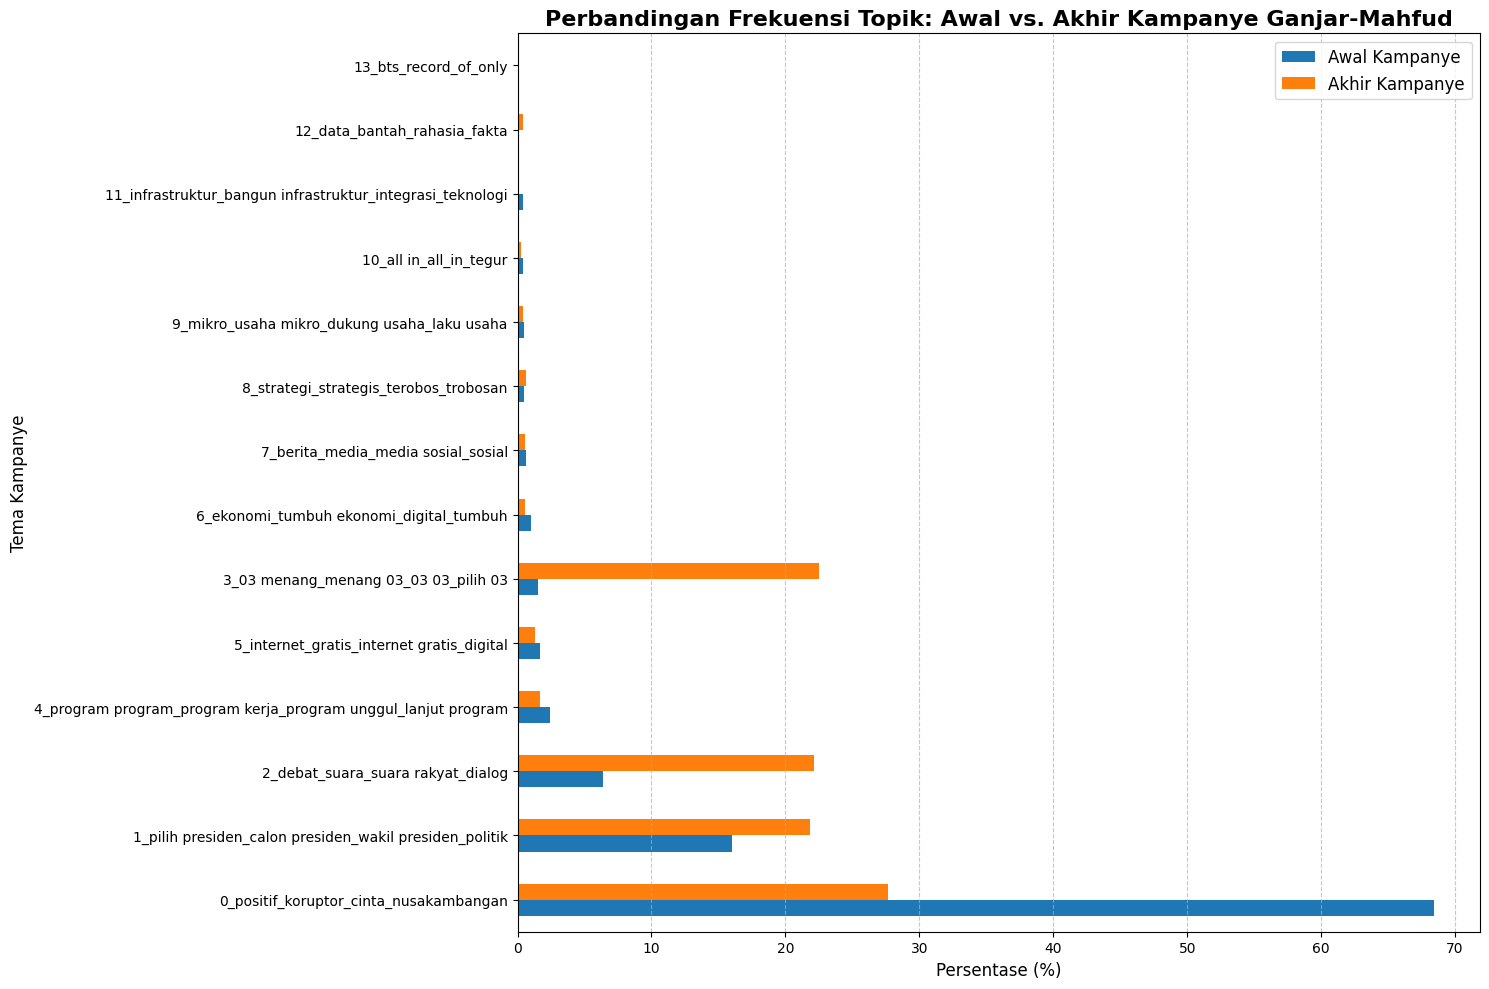


=== RINGKASAN ANALISIS TOPIK DARI WAKTU KE WAKTU ===

Periode Awal (2023-11-01 hingga 2023-12-23):


TypeError: 'zip' object is not subscriptable

In [10]:
# Divide the campaign period into early and late periods for comparison
mid_point = sorted(df_03['date'].unique())[len(sorted(df_03['date'].unique()))//2]
early_period = df_03[df_03['date'] < mid_point]
late_period = df_03[df_03['date'] >= mid_point]

# Get topic distributions for each period
early_topics, _ = topic_model.transform(early_period['full_text'].tolist())
late_topics, _ = topic_model.transform(late_period['full_text'].tolist())

# Calculate topic frequencies for each period (excluding outliers)
early_freq = pd.Series([t for t in early_topics if t != -1]).value_counts(normalize=True)
late_freq = pd.Series([t for t in late_topics if t != -1]).value_counts(normalize=True)

# Create a comparative visualization
plt.figure(figsize=(15, 10))

# Get all topics that appear in either period
all_topics = sorted(set(early_freq.index) | set(late_freq.index))
topic_labels_list = [topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == t, "Name"].values[0] 
                for t in all_topics]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Awal Kampanye': [early_freq.get(t, 0) * 100 for t in all_topics],
    'Akhir Kampanye': [late_freq.get(t, 0) * 100 for t in all_topics]
}, index=topic_labels_list)

# Sort by overall frequency
comparison_df = comparison_df.sort_values(by=['Awal Kampanye', 'Akhir Kampanye'], ascending=False)

# Create a horizontal bar chart
comparison_df.plot.barh(figsize=(15, 10))
plt.title('Perbandingan Frekuensi Topik: Awal vs. Akhir Kampanye Ganjar-Mahfud', fontsize=16, fontweight='bold')
plt.xlabel('Persentase (%)', fontsize=12)
plt.ylabel('Tema Kampanye', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print summary findings
print("\n=== RINGKASAN ANALISIS TOPIK DARI WAKTU KE WAKTU ===\n")
print(f"Periode Awal ({early_period['date'].min()} hingga {early_period['date'].max()}):")
for topic, pct in early_freq.items()[:5]:
    topic_label = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic, "Name"].values[0]
    print(f"- {topic_label}: {pct*100:.1f}%")

print(f"\nPeriode Akhir ({late_period['date'].min()} hingga {late_period['date'].max()}):")
for topic, pct in late_freq.items()[:5]:
    topic_label = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic, "Name"].values[0]
    print(f"- {topic_label}: {pct*100:.1f}%")